In [1]:
import cv2  
import numpy as np  
import requests       # To load image from url
from PIL import Image  # For handling image files
from io import BytesIO  # For handling in-memory binary data
import matplotlib.pyplot as plt  # For displaying images
import ipywidgets as widgets  # For interactive widgets
from IPython.display import display, clear_output  # For output clearing in widgets

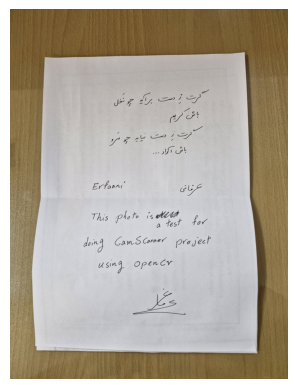

In [2]:
response = requests.get('https://i.postimg.cc/RCsbzQ6c/20250118-131532.jpg')
img = Image.open(BytesIO(response.content))

# show imported image
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
# Function to process the image
def CamScanner_clean(img):
    # Convert image to numpy array
    img = np.array(img)

    # Change image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to create a binary image
    _, mask_page = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(mask_page, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Show all contours on the original image for debugging
    debug_img = img.copy()
    cv2.drawContours(debug_img, contours, -1, (0, 255, 0), 3)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title('Contours Debugging')
    plt.axis('off')
    plt.show()

    # Define lists to store area and perimeter
    area_list = []
    p_list = []

    # Loop through contours to calculate area and perimeter
    for cont in contours:
        area = cv2.contourArea(cont)
        area_list.append(area)
        p = cv2.arcLength(cont, True)
        p_list.append(p)

    # Check if any contours are detected
    if len(area_list) == 0:
        print("No contours detected. Ensure the image is properly preprocessed.")
        return

    # Get the index of the largest contour
    page_index = np.argmax(area_list)

    # Approximate the polygon of the largest contour
    RasPoz = cv2.approxPolyDP(curve=contours[page_index], epsilon=0.01 * p_list[page_index], closed=True)

    # Ensure the polygon is a rectangle (4 points)
    if len(RasPoz) == 4:
        RasPoz_reshaped = np.reshape(RasPoz, (4, 2))

        # Sort points to maintain proper orientation
        sorted_points = sorted(RasPoz_reshaped, key=lambda x: (x[1], x[0]))
        top_points = sorted(sorted_points[:2], key=lambda x: x[0])
        bottom_points = sorted(sorted_points[2:], key=lambda x: x[0], reverse=True)
        ordered_points = np.array(top_points + bottom_points, dtype='float32')

        # Define the destination points for perspective transformation
        h, w, _ = img.shape
        p2 = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

        # Get the perspective transform matrix
        arr_pres = cv2.getPerspectiveTransform(ordered_points, p2)

        # Apply perspective transformation to the original image
        selected_page = cv2.warpPerspective(img, arr_pres, (w, h))

        # Convert the selected page to grayscale and apply adaptive thresholding
        selected_gray = cv2.cvtColor(selected_page, cv2.COLOR_BGR2GRAY)
        adaptive_selected = cv2.adaptiveThreshold(selected_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 12)

        # Show original and output images
        plt.figure(figsize=(15, 10))
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        # Processed image
        plt.subplot(1, 2, 2)
        plt.imshow(adaptive_selected, cmap='gray')
        plt.title('Processed Image (Clean Output)')
        plt.axis('off')
        plt.show()
    else:
        print("Contours detected do not form a rectangle. Adjust threshold or image preprocessing.")


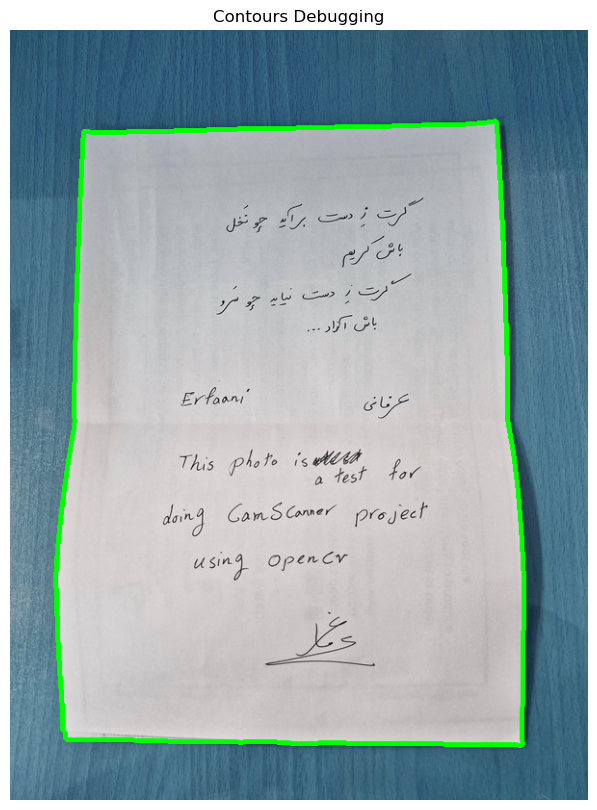

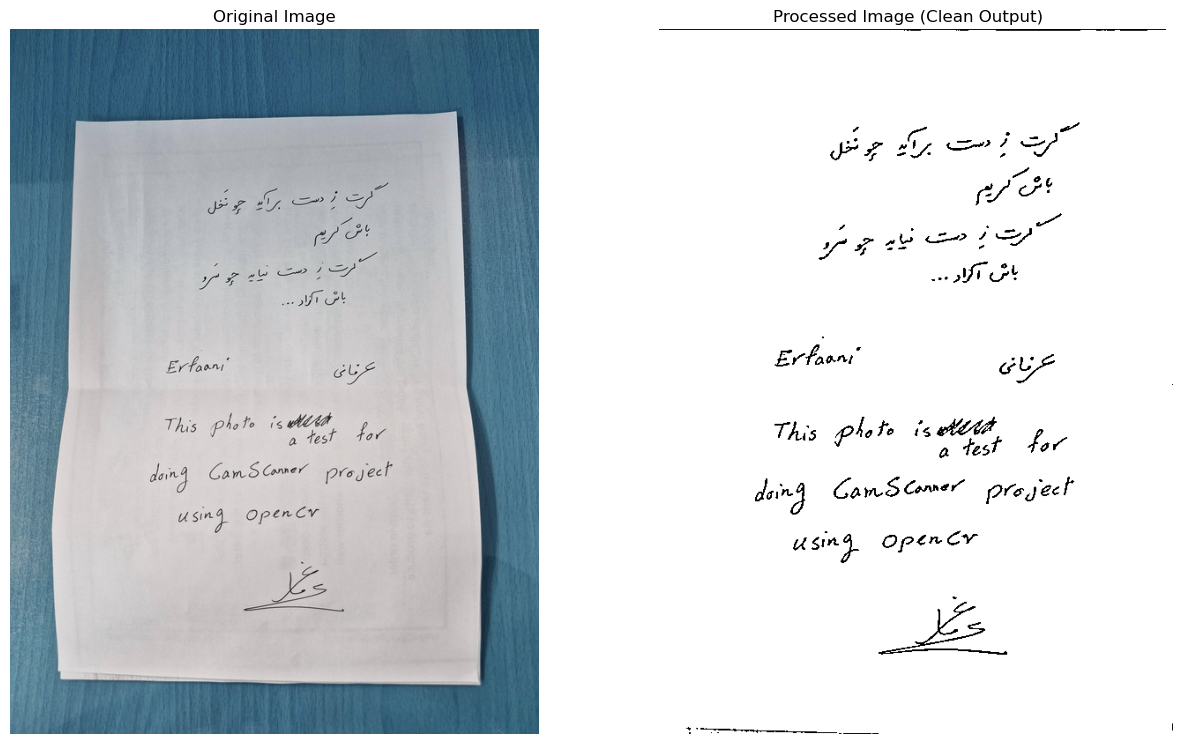

In [4]:
# Call the clean function
CamScanner_clean(img)

In [5]:
# Create File Upload widget
upload = widgets.FileUpload(accept='.jpg,.png', multiple=False)
button = widgets.Button(description='Process Image', button_style='info')
out = widgets.Output()

# Define callback function for button click
def on_button_clicked(_):
    with out:
        clear_output()  # Clear previous output
        try:
            # Check if a file is uploaded
            if not upload.value:
                print('No file uploaded. Please upload an image file!')
                return
            
            # Debugging: Check the structure of upload.value
            print("Upload Value Structure:", upload.value)

            # Extract file content
            uploaded_file = list(upload.value.values())[0]  # Get the first uploaded file
            data = BytesIO(uploaded_file['content'])
            img = Image.open(data)

            # Display uploaded image
            print("Uploaded Image:")
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # Process and display the result
            print("Processed Image:")
            CamScanner_clean(img)
            
        except Exception as e:
            print(f"Error Type: {type(e).__name__}, Error Details: {e}")
            print("Please upload a valid image file (e.g., .jpg or .png).")

# Attach callback to button
button.on_click(on_button_clicked)

# Display the UI
display(widgets.VBox([upload, button, out]))


